<a href="https://colab.research.google.com/github/geraldHoff/570_Gaussian_Process/blob/main/Gaussian_process_for_MSP_of_sustainable_aviation_fue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Celda 1: subir y leer el Excel actual (Ethanol_price en USD/L) ===
from google.colab import files
import io
import pandas as pd
import numpy as np

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print("Archivo cargado:", file_name)

df = pd.read_excel(io.BytesIO(uploaded[file_name]))

print("Columnas del dataset:")
print(df.columns.tolist())

print("\nPrimeras filas:")
display(df.head())


Saving datos_MESP_finals.xlsx to datos_MESP_finals.xlsx
Archivo cargado: datos_MESP_finals.xlsx
Columnas del dataset:
['run', 'SAF_MSPSmall', 'Ethanol_price', 'Diesel_local_price', 'Electricity_rate', 'Price_Natural_Gas', 'Gasoline_local_price', 'Hydrogen_price', 'Loan_interest_rate', 'Clean_fuels_tax_credit']

Primeras filas:


,run,SAF_MSPSmall,Ethanol_price,Diesel_local_price,Electricity_rate,Price_Natural_Gas,Gasoline_local_price,Hydrogen_price,Loan_interest_rate,Clean_fuels_tax_credit
0,1,2.030,0.852407,1.150,0.2150,5.75,1.150,1460,0.0800,0.750
1,2,1.420,0.524862,0.725,0.3080,7.88,0.725,1730,0.0450,1.130
2,3,2.630,1.176006,1.580,0.1230,3.63,1.580,1180,0.1150,0.375
3,4,2.570,1.010260,0.938,0.2610,4.69,0.513,1050,0.1320,1.310
4,5,0.684,0.362273,1.790,0.0763,8.94,1.360,1590,0.0625,0.563


Kernel ajustado:
0.896**2 * RBF(length_scale=[0.33, 14.5, 8.26, 1e+05, 2.02, 8.37e+04, 6.44, 1e+05])

Mejor SAF_MSPSmall observado (best_MESP): 0.5180
R2 en entrenamiento: 1.0000
RMSE en entrenamiento: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 7 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


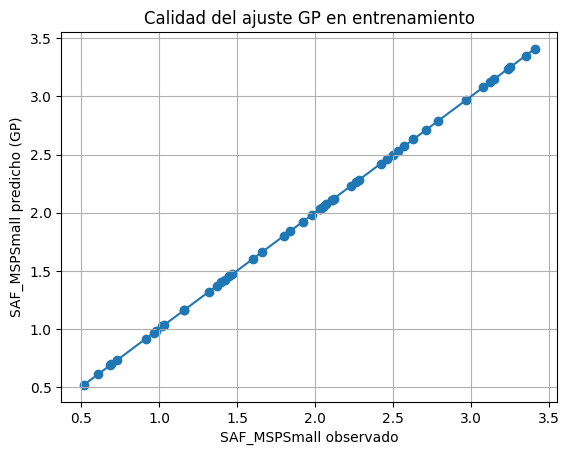

In [ ]:
# === Celda 2: preparar datos, entrenar GP y evaluar calidad ===

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Nombre de la columna objetivo
target_col = "SAF_MSPSmall"

# Columnas de entrada (todas en unidades físicas correctas, por ej. Ethanol_price en USD/L)
feature_cols = [
    "Ethanol_price",
    "Diesel_local_price",
    "Electricity_rate",
    "Price_Natural_Gas",
    "Gasoline_local_price",
    "Hydrogen_price",
    "Loan_interest_rate",
    "Clean_fuels_tax_credit",
]

# Matrices de datos
X = df[feature_cols].values
y = df[target_col].values

# Escalado
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Kernel GP (sin ruido explícito)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(X.shape[1]))

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-6,          # pequeño ruido numérico
    normalize_y=False,
    n_restarts_optimizer=5,
    random_state=0,
)

gp.fit(X_scaled, y_scaled)

print("Kernel ajustado:")
print(gp.kernel_)

# ----- Métricas de calidad en entrenamiento -----

# Predicción sobre los mismos puntos
y_pred_scaled = gp.predict(X_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

r2_train = r2_score(y, y_pred)
rmse_train = np.sqrt(mean_squared_error(y, y_pred))
best_MESP = float(np.nanmin(y))

print(f"\nMejor SAF_MSPSmall observado (best_MESP): {best_MESP:.4f}")
print(f"R2 en entrenamiento: {r2_train:.4f}")
print(f"RMSE en entrenamiento: {rmse_train:.4f}")

# Scatter observado vs predicho
plt.figure()
plt.scatter(y, y_pred)
plt.xlabel("SAF_MSPSmall observado")
plt.ylabel("SAF_MSPSmall predicho (GP)")
plt.title("Calidad del ajuste GP en entrenamiento")
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.grid(True)
plt.show()


In [ ]:
# === Celda 3: función de adquisición + evitar puntos duplicados ===

# Límites de búsqueda (ajústalos según tu caso, todos en unidades físicas)
bounds = {
    "Ethanol_price": (0.20, 1.50),           # USD/L
    "Diesel_local_price": (0.30, 2.00),
    "Gasoline_local_price": (0.30, 2.00),
    "Electricity_rate": (0.03, 0.40),        # USD/kWh (ejemplo)
    "Price_Natural_Gas": (1.50, 10.0),       # USD/MMBtu (ejemplo)
    "Hydrogen_price": (400, 2000),            # USD/kg (ejemplo)
    "Loan_interest_rate": (0.01, 0.15),      # fracción
    "Clean_fuels_tax_credit": (0.00, 1.50),  # USD/gal equivalente (ejemplo)
}

print("Límites de búsqueda usados:")
for k, (a, b) in bounds.items():
    print(f"{k}: {a} → {b}")

# Generar candidatos aleatorios dentro de los bounds
n_candidates = 5000
rng = np.random.RandomState(0)

cand_matrix = np.column_stack([
    rng.uniform(bounds[col][0], bounds[col][1], n_candidates)
    for col in feature_cols
])

cand_scaled = x_scaler.transform(cand_matrix)

# Predicción GP para candidatos
mean_cand, std_cand = gp.predict(cand_scaled, return_std=True)
var_cand = std_cand**2

# Máxima desviación estándar (medida global de incertidumbre)
max_std = float(np.max(std_cand))
print(f"\nMáxima desviación estándar (max_std) en candidatos: {max_std:.4f}")

# ------- Filtro anti-duplicados -------

def is_duplicate(x_next, df, feature_cols, tol=1e-6):
    """Devuelve True si x_next ya está (o casi) en el dataset."""
    X_existing = df[feature_cols].values
    diffs = np.abs(X_existing - x_next)
    return np.any(np.all(diffs <= tol, axis=1))

# Ordenar candidatos por varianza descendente
order = np.argsort(-var_cand)

x_next = None
best_idx = None

for idx in order:
    cand = cand_matrix[idx]
    if not is_duplicate(cand, df, feature_cols, tol=1e-6):
        x_next = cand
        best_idx = idx
        break

if x_next is None:
    print("\n⚠ Todos los candidatos son duplicados. Quizás necesitas ampliar rangos.")
else:
    print("\nNuevo punto sugerido (no duplicado) para Stella:")
    for col, val in zip(feature_cols, x_next):
        print(f"{col:25s}: {val:.6f}")


Límites de búsqueda usados:
Ethanol_price: 0.2 → 1.5
Diesel_local_price: 0.3 → 2.0
Gasoline_local_price: 0.3 → 2.0
Electricity_rate: 0.03 → 0.4
Price_Natural_Gas: 1.5 → 10.0
Hydrogen_price: 400 → 2000
Loan_interest_rate: 0.01 → 0.15
Clean_fuels_tax_credit: 0.0 → 1.5

Máxima desviación estándar (max_std) en candidatos: 0.5499

Nuevo punto sugerido (no duplicado) para Stella:
Ethanol_price            : 0.217795
Diesel_local_price       : 1.692364
Electricity_rate         : 0.049761
Price_Natural_Gas        : 7.015569
Gasoline_local_price     : 0.333785
Hydrogen_price           : 1791.302309
Loan_interest_rate       : 0.137231
Clean_fuels_tax_credit   : 0.591725


In [ ]:
# === Celda 4: añadir la fila sugerida al dataset y guardar Excel ===

if x_next is None:
    print("No se añadió ninguna fila nueva porque todos los candidatos eran duplicados.")
else:
    # Asumimos que los primeros 50 runs son el diseño inicial
    initial_runs = 50
    current_runs = len(df)
    iteration = max(current_runs - initial_runs, 0)

    next_run = int(df["run"].max()) + 1

    new_row = {"run": next_run, target_col: np.nan}
    for col, val in zip(feature_cols, x_next):
        new_row[col] = val

    df_next = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    print(f"\nFila nueva añadida (run = {next_run}, iteración = {iteration}):")
    display(df_next.tail())

    # Guardar dataset actualizado
    updated_data_file = "datos_MESP_next.xlsx"
    df_next.to_excel(updated_data_file, index=False)

    from google.colab import files
    files.download(updated_data_file)



Fila nueva añadida (run = 51, iteración = 0):


,run,SAF_MSPSmall,Ethanol_price,Diesel_local_price,Electricity_rate,Price_Natural_Gas,Gasoline_local_price,Hydrogen_price,Loan_interest_rate,Clean_fuels_tax_credit
46,47,1.02,0.505130,1.500000,0.093600,2.430000,1.600000,1130.000000,0.108000,0.773000
47,48,1.84,0.789266,0.698000,0.128000,2.160000,1.970000,1780.000000,0.148000,1.480000
48,49,3.35,1.436464,1.550000,0.313000,6.410000,1.120000,1230.000000,0.077800,0.727000
49,50,1.16,0.464088,1.120000,0.221000,8.540000,1.550000,961.000000,0.113000,0.352000
50,51,NaN,0.217795,1.692364,0.049761,7.015569,0.333785,1791.302309,0.137231,0.591725


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# === Celda 5: registrar calidad del modelo y adquisición en un log ===

import os
import csv

log_file = "gp_progress_log.csv"

# Crear archivo con cabecera si no existe
if not os.path.exists(log_file):
    with open(log_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "n_runs", "best_MESP", "max_std", "R2_train", "RMSE_train"])

n_runs = len(df)

# Añadir fila de esta iteración
with open(log_file, "a", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([iteration, n_runs, best_MESP, max_std, r2_train, rmse_train])

# Leer log
log_df = pd.read_csv(log_file)
print("Historial de progreso del GP:")
display(log_df)

from google.colab import files
files.download(log_file)


Historial de progreso del GP:


,iteration,n_runs,best_MESP,max_std,R2_train,RMSE_train
0,0,50,0.518,0.549851,1.0,0.000004


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

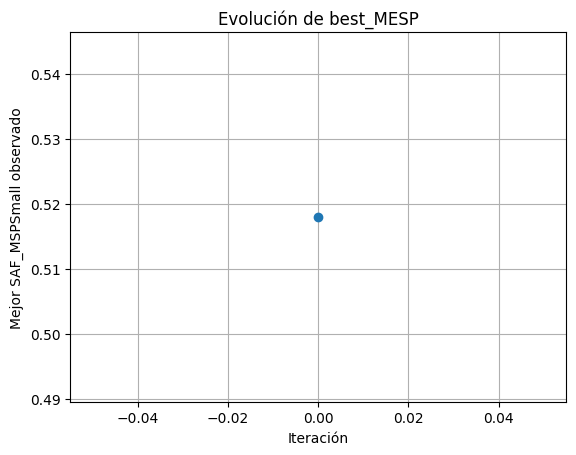

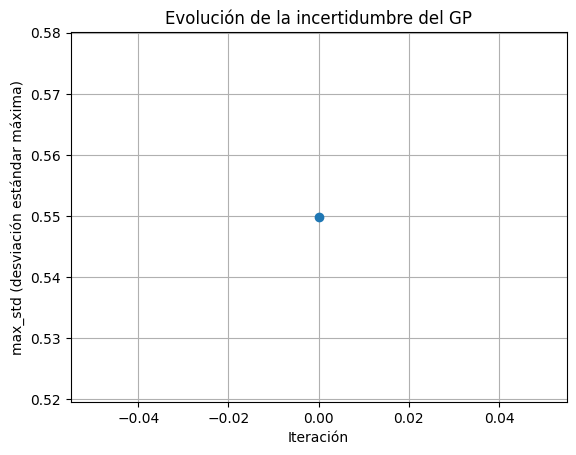

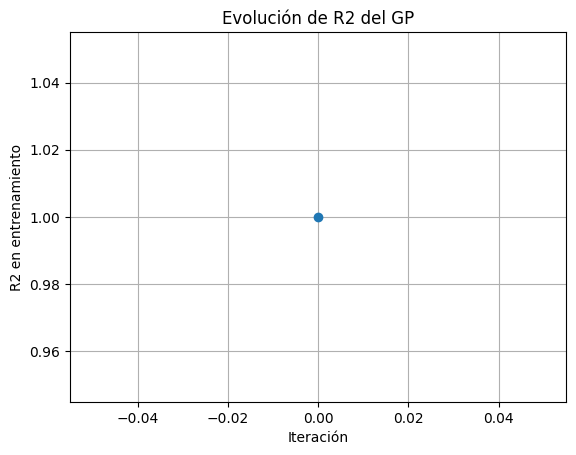

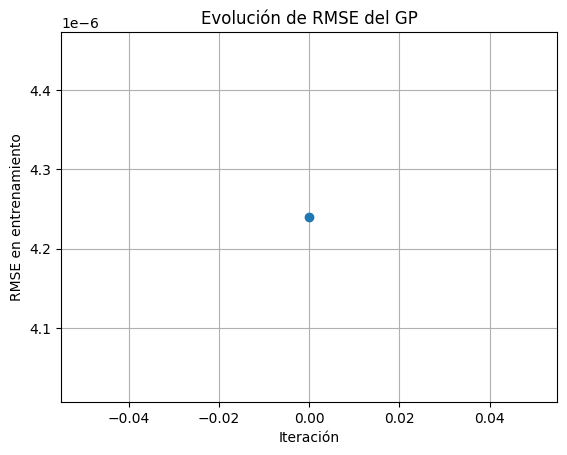

In [ ]:
# === Celda 6: gráficas de calidad del modelo y exploración ===
import matplotlib.pyplot as plt
import pandas as pd

log_df = pd.read_csv("gp_progress_log.csv")

# best_MESP por iteración
plt.figure()
plt.plot(log_df["iteration"], log_df["best_MESP"], marker="o")
plt.xlabel("Iteración")
plt.ylabel("Mejor SAF_MSPSmall observado")
plt.title("Evolución de best_MESP")
plt.grid(True)
plt.show()

# max_std por iteración
plt.figure()
plt.plot(log_df["iteration"], log_df["max_std"], marker="o")
plt.xlabel("Iteración")
plt.ylabel("max_std (desviación estándar máxima)")
plt.title("Evolución de la incertidumbre del GP")
plt.grid(True)
plt.show()

# R2
plt.figure()
plt.plot(log_df["iteration"], log_df["R2_train"], marker="o")
plt.xlabel("Iteración")
plt.ylabel("R2 en entrenamiento")
plt.title("Evolución de R2 del GP")
plt.grid(True)
plt.show()

# RMSE
plt.figure()
plt.plot(log_df["iteration"], log_df["RMSE_train"], marker="o")
plt.xlabel("Iteración")
plt.ylabel("RMSE en entrenamiento")
plt.title("Evolución de RMSE del GP")
plt.grid(True)
plt.show()


In [ ]:
# === Celda 7: crear Excel final con datos + progreso del GP ===

!pip install xlsxwriter

import pandas as pd

# df_next debe ser el dataset con la última fila añadida
# si no está en memoria, puedes leer el Excel final:
# df_next = pd.read_excel("datos_MESP_next.xlsx")

log_df = pd.read_csv("gp_progress_log.csv")

final_excel = "SAF_GP_results.xlsx"

with pd.ExcelWriter(final_excel, engine="xlsxwriter") as writer:
    df_next.to_excel(writer, sheet_name="data", index=False)
    log_df.to_excel(writer, sheet_name="progress", index=False)

print("Excel final creado:", final_excel)

from google.colab import files
files.download(final_excel)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 3.9 MB/s eta 0:00:00
Excel final creado: SAF_GP_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

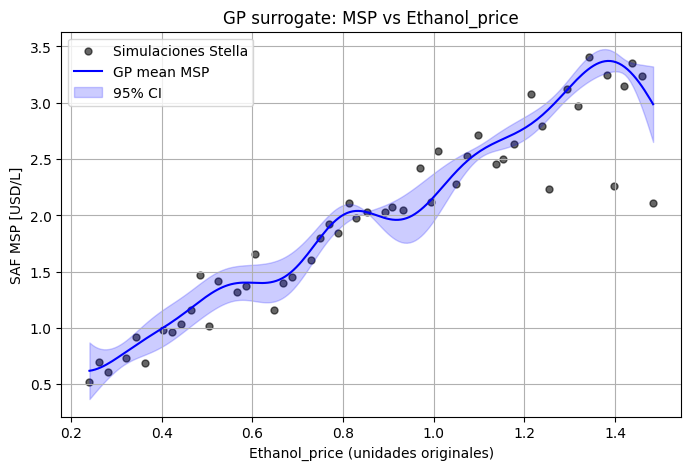

In [ ]:
# === Celda 8: Curva 1D del GP (MSP vs una variable) ===
import numpy as np
import matplotlib.pyplot as plt

# -------- 1. Elegir la variable de entrada a visualizar --------
# Debe ser una de las columnas en feature_cols
feature_name = "Ethanol_price"   # puedes cambiar a "Hydrogen_price", etc.
feature_idx = feature_cols.index(feature_name)

# -------- 2. Construir un grid 1D variando SOLO esa variable --------
X_all = df[feature_cols].values        # todos los inputs en unidades originales
y_all = df[target_col].values          # MSP original

x_mean = X_all.mean(axis=0)            # punto de referencia (media de cada variable)

n_points = 200
feature_min = X_all[:, feature_idx].min()
feature_max = X_all[:, feature_idx].max()

x_grid = np.linspace(feature_min, feature_max, n_points)

# Matriz de puntos donde solo cambia esa variable
X_plot = np.tile(x_mean, (n_points, 1))
X_plot[:, feature_idx] = x_grid

# -------- 3. Escalar y predecir con el GP --------
X_plot_scaled = x_scaler.transform(X_plot)
mean_scaled, std_scaled = gp.predict(X_plot_scaled, return_std=True)

# Invertir escala de MSP
y_mean = y_scaler.inverse_transform(mean_scaled.reshape(-1, 1)).ravel()
y_std = std_scaled * y_scaler.scale_[0]   # re-escalar desviación estándar

# -------- 4. Proyectar los datos de Stella sobre esa variable --------
x_train_feat = X_all[:, feature_idx]
y_train = y_all

# -------- 5. Graficar --------
plt.figure(figsize=(8,5))
plt.scatter(x_train_feat, y_train,
            c='k', s=25, alpha=0.6,
            label="Simulaciones Stella")
plt.plot(x_grid, y_mean, 'b-', label="GP mean MSP")
plt.fill_between(x_grid,
                 y_mean - 1.96*y_std,
                 y_mean + 1.96*y_std,
                 color='blue', alpha=0.2,
                 label="95% CI")

plt.xlabel(f"{feature_name} (unidades originales)")
plt.ylabel("SAF MSP [USD/L]")
plt.title(f"GP surrogate: MSP vs {feature_name}")
plt.legend()
plt.grid(True)
plt.show()



Generando curva GP para: Ethanol_price


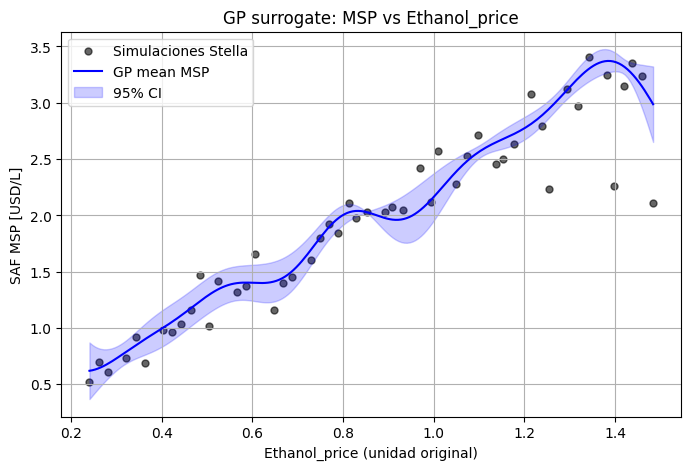


Generando curva GP para: Diesel_local_price


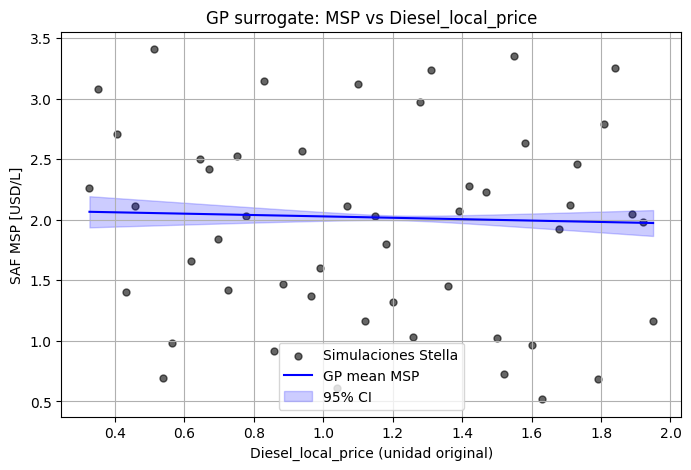


Generando curva GP para: Electricity_rate


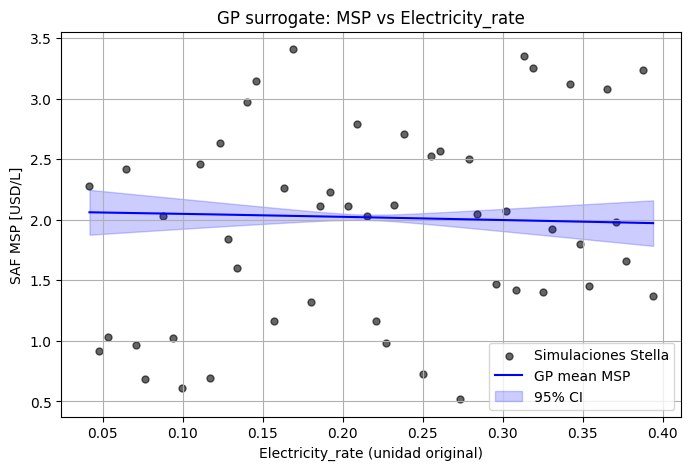


Generando curva GP para: Price_Natural_Gas


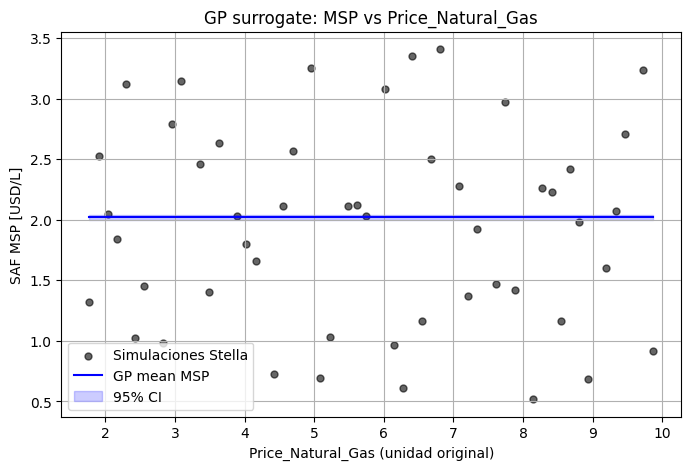


Generando curva GP para: Gasoline_local_price


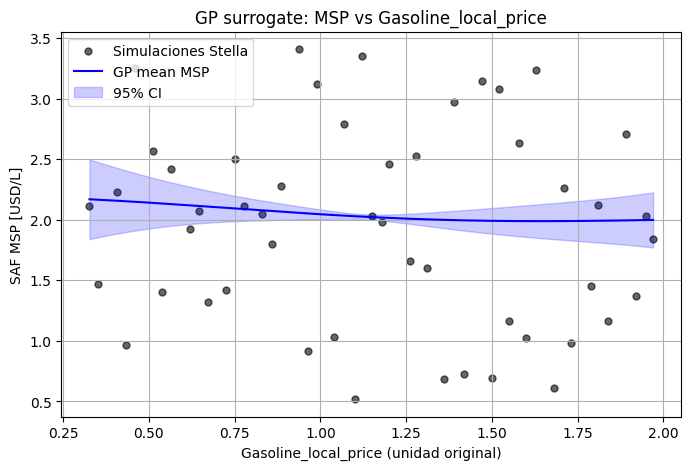


Generando curva GP para: Hydrogen_price


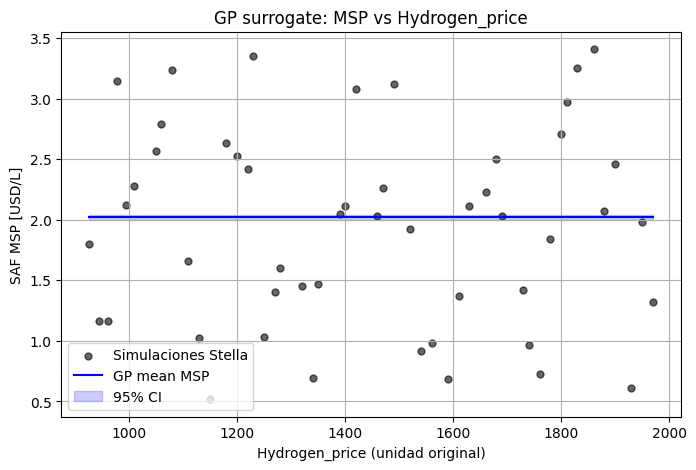


Generando curva GP para: Loan_interest_rate


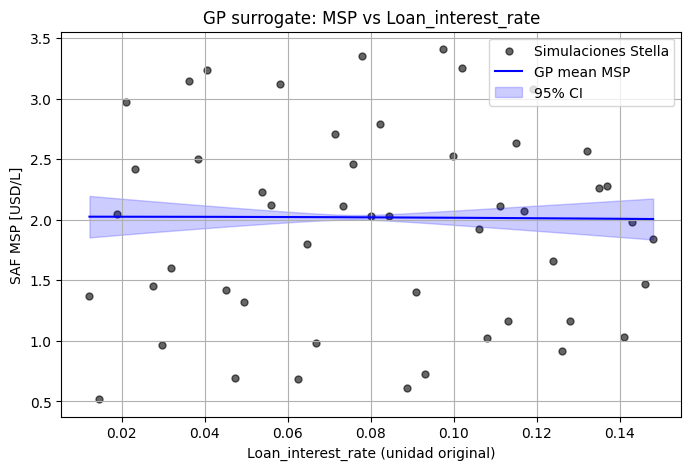


Generando curva GP para: Clean_fuels_tax_credit


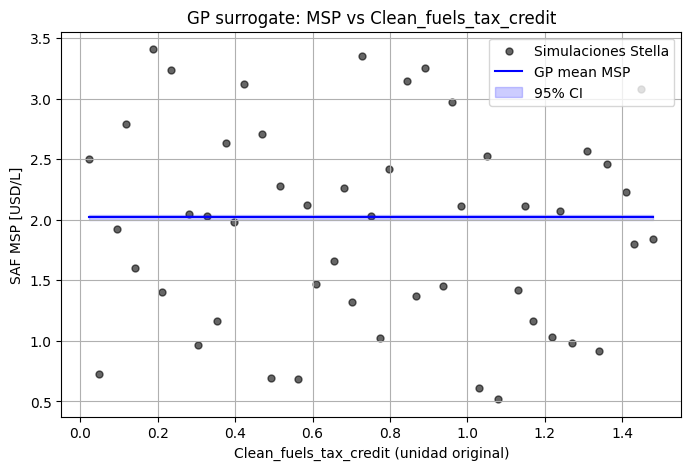

In [ ]:
# === Celda 8: Curvas GP MSP vs cada variable (todas los inputs) ===
import numpy as np
import matplotlib.pyplot as plt

X_all = df[feature_cols].values
y_all = df[target_col].values

# Punto de referencia: media de cada variable
x_mean = X_all.mean(axis=0)

# Crear una figura individual por cada variable
for feature_idx, feature_name in enumerate(feature_cols):

    print(f"\nGenerando curva GP para: {feature_name}")

    # --- 1. Rango de esa variable según datos existentes ---
    n_points = 200
    feature_min = X_all[:, feature_idx].min()
    feature_max = X_all[:, feature_idx].max()
    x_grid = np.linspace(feature_min, feature_max, n_points)

    # --- 2. Matriz X donde solo varía esta variable ---
    X_plot = np.tile(x_mean, (n_points, 1))
    X_plot[:, feature_idx] = x_grid

    # --- 3. Escalar y predecir con el GP ---
    X_plot_scaled = x_scaler.transform(X_plot)
    mean_scaled, std_scaled = gp.predict(X_plot_scaled, return_std=True)

    # MSP desescalado
    y_mean = y_scaler.inverse_transform(mean_scaled.reshape(-1, 1)).ravel()
    y_std = std_scaled * y_scaler.scale_[0]  # rescale std

    # --- 4. Datos reales proyectados sobre esa variable ---
    x_train_feat = X_all[:, feature_idx]
    y_train = y_all

    # --- 5. Gráfico ---
    plt.figure(figsize=(8,5))
    plt.scatter(x_train_feat, y_train,
                c='k', s=25, alpha=0.6,
                label="Simulaciones Stella")

    plt.plot(x_grid, y_mean, 'b-', label="GP mean MSP")

    plt.fill_between(x_grid,
                     y_mean - 1.96*y_std,
                     y_mean + 1.96*y_std,
                     color='blue', alpha=0.2,
                     label="95% CI")

    plt.xlabel(f"{feature_name} (unidad original)")
    plt.ylabel("SAF MSP [USD/L]")
    plt.title(f"GP surrogate: MSP vs {feature_name}")
    plt.grid(True)
    plt.legend()
    plt.show()
